In [1]:
# Remember to adjust your student ID in meta.xml
import numpy as np
import pickle
import random
import gym
from simple_custom_taxi_env import SimpleTaxiEnv
from tqdm import tqdm
import globals

c:\Users\qwer9\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
def find_nearest_station(taxi_pos, station):
    distance = np.inf
    for (x,y) in station:
        temp_distance = abs(taxi_pos[0] - x) + abs(taxi_pos[1] - y)
        if temp_distance < distance:
            distance = temp_distance
            goal = (x, y)
    return goal

In [3]:
def table_q_learning(
    episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1 if i < 0.1 * episode else 1000
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        # Setup global variables
        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal

        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent observations
            adjacent = {
                (taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col),
                (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1),
                (taxi_row, taxi_col)
            }

            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)

            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Goal logic
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 20
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 30
                        if saved:
                            print("Passenger Dropped in a wrong place")
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            # Compute next state
            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
                relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += shaped_reward

            if saved:
                print(f"Shaped_Reward: {shaped_reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [20]:
q_table, total_rewards = table_q_learning(episode = 1000000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.01, epsilon_decay = 0.9999, memory = 100000)
save_q_table(q_table)

  1%|▏         | 13766/1000000 [00:01<01:07, 14555.30it/s]

Episode: 10000/1000000, Total Reward: -22.1, Steps: 1, Epsilon: 0.3679


  2%|▏         | 22569/1000000 [00:01<01:08, 14281.64it/s]

Episode: 20000/1000000, Total Reward: -14.1, Steps: 1, Epsilon: 0.1353


  3%|▎         | 31633/1000000 [00:02<01:28, 10914.94it/s]

Episode: 30000/1000000, Total Reward: -18.1, Steps: 1, Epsilon: 0.0498


  4%|▍         | 42683/1000000 [00:03<01:28, 10832.57it/s]

Episode: 40000/1000000, Total Reward: -13.1, Steps: 1, Epsilon: 0.0183


  5%|▌         | 52140/1000000 [00:04<01:24, 11184.90it/s]

Episode: 50000/1000000, Total Reward: -11.1, Steps: 1, Epsilon: 0.0100


  6%|▌         | 62423/1000000 [00:05<01:13, 12801.18it/s]

Episode: 60000/1000000, Total Reward: -17.1, Steps: 1, Epsilon: 0.0100


  7%|▋         | 73458/1000000 [00:06<01:00, 15434.35it/s]

Episode: 70000/1000000, Total Reward: -12.1, Steps: 1, Epsilon: 0.0100


  8%|▊         | 84367/1000000 [00:06<00:50, 18106.76it/s]

Episode: 80000/1000000, Total Reward: -14.1, Steps: 1, Epsilon: 0.0100


  9%|▉         | 93547/1000000 [00:07<00:49, 18129.35it/s]

Episode: 90000/1000000, Total Reward: -13.1, Steps: 1, Epsilon: 0.0100


 10%|▉         | 99204/1000000 [00:07<00:52, 17308.34it/s]

==========================100000th episodes Start!==========================

Step: 1
Taxi Position: (2, 1)
Passenger Position: (0, 3) 
Destination: (4, 1)
Fuel Left: None
Last Action: Move North

B . G . .
. . 🚖 . D
. . . . .
P . . B .
. . Y . .


Shaped_Reward: -13.1, Reward: -10.1
Episode: 100000/1000000, Total Reward: -13.1, Steps: 1, Epsilon: 0.0100


 11%|█         | 110046/1000000 [00:48<58:54, 251.76it/s]  

Episode: 110000/1000000, Total Reward: 122.1, Steps: 19, Epsilon: 0.0100


 12%|█▏        | 120016/1000000 [01:31<1:13:55, 198.41it/s]

Episode: 120000/1000000, Total Reward: 132.9, Steps: 11, Epsilon: 0.0100


 13%|█▎        | 130068/1000000 [02:10<47:58, 302.24it/s]  

Episode: 130000/1000000, Total Reward: 148.9, Steps: 11, Epsilon: 0.0100


 14%|█▍        | 140020/1000000 [02:46<1:22:22, 173.99it/s]

Episode: 140000/1000000, Total Reward: -3048.199999999987, Steps: 232, Epsilon: 0.0100


 15%|█▌        | 150041/1000000 [03:24<1:03:51, 221.82it/s]

Episode: 150000/1000000, Total Reward: 101.99999999999999, Steps: 20, Epsilon: 0.0100


 16%|█▌        | 160059/1000000 [04:00<39:42, 352.54it/s]  

Episode: 160000/1000000, Total Reward: 158.20000000000002, Steps: 8, Epsilon: 0.0100


 17%|█▋        | 170042/1000000 [04:32<44:57, 307.63it/s]  

Episode: 170000/1000000, Total Reward: 136.5, Steps: 15, Epsilon: 0.0100


 18%|█▊        | 180064/1000000 [05:05<32:58, 414.40it/s]  

Episode: 180000/1000000, Total Reward: 115.19999999999999, Steps: 18, Epsilon: 0.0100


 19%|█▉        | 190070/1000000 [05:42<40:49, 330.62it/s]  

Episode: 190000/1000000, Total Reward: -3038.99999999995, Steps: 1000, Epsilon: 0.0100


 20%|██        | 200070/1000000 [06:13<41:22, 322.17it/s]  

==========================200000th episodes Start!==========================

Step: 1
Taxi Position: (3, 3)
Passenger Position: (4, 1) 
Destination: (1, 0)
Fuel Left: None
Last Action: Move South

. D . . .
. . . . P
. . B . .
Y . . 🚖 .
. B . G .


Shaped_Reward: -4.1, Reward: -0.1

Step: 2
Taxi Position: (3, 4)
Passenger Position: (4, 1) 
Destination: (1, 0)
Fuel Left: None
Last Action: Move West

. D . . .
. . . . P
. . B . .
Y . . . .
. B . 🚖 .


Shaped_Reward: -3.1, Reward: -0.1

Step: 3
Taxi Position: (2, 4)
Passenger Position: (4, 1) 
Destination: (1, 0)
Fuel Left: None
Last Action: Move East

. D . . .
. . . . P
. . B . .
Y . . . .
. B 🚖 G .


Shaped_Reward: -4.1, Reward: -0.1

Step: 4
Taxi Position: (3, 4)
Passenger Position: (4, 1) 
Destination: (1, 0)
Fuel Left: None
Last Action: Move West

. D . . .
. . . . P
. . B . .
Y . . . .
. B . 🚖 .


Shaped_Reward: -3.1, Reward: -0.1

Step: 5
Taxi Position: (2, 4)
Passenger Position: (4, 1) 
Destination: (1, 0)
Fuel Left: None
Last Ac

 21%|██        | 210026/1000000 [06:43<41:09, 319.95it/s]  

Episode: 210000/1000000, Total Reward: -3311.9999999999504, Steps: 1000, Epsilon: 0.0100


 22%|██▏       | 220023/1000000 [07:19<56:19, 230.80it/s]  

Episode: 220000/1000000, Total Reward: 132.5, Steps: 15, Epsilon: 0.0100


 23%|██▎       | 230052/1000000 [07:48<41:40, 307.86it/s]  

Episode: 230000/1000000, Total Reward: -377.00000000000284, Steps: 310, Epsilon: 0.0100


 24%|██▍       | 240064/1000000 [08:17<32:53, 385.05it/s]  

Episode: 240000/1000000, Total Reward: 92.9, Steps: 21, Epsilon: 0.0100


 25%|██▌       | 250015/1000000 [08:47<41:48, 298.97it/s]  

Episode: 250000/1000000, Total Reward: 165.4, Steps: 6, Epsilon: 0.0100


 26%|██▌       | 260117/1000000 [09:17<30:43, 401.32it/s]  

Episode: 260000/1000000, Total Reward: 50.90000000000005, Steps: 31, Epsilon: 0.0100


 27%|██▋       | 270058/1000000 [09:43<31:22, 387.76it/s]  

Episode: 270000/1000000, Total Reward: 151.9, Steps: 11, Epsilon: 0.0100


 28%|██▊       | 280044/1000000 [10:10<29:23, 408.19it/s]

Episode: 280000/1000000, Total Reward: 158.1, Steps: 9, Epsilon: 0.0100


 29%|██▉       | 290045/1000000 [10:37<23:31, 503.14it/s]  

Episode: 290000/1000000, Total Reward: 135.4, Steps: 16, Epsilon: 0.0100


 30%|███       | 300065/1000000 [11:05<22:16, 523.68it/s]

==========================300000th episodes Start!==========================

Step: 1
Taxi Position: (7, 3)
Passenger Position: (2, 1) 
Destination: (4, 5)
Fuel Left: None
Last Action: Move South

. . B . . . B . .
. . P . . R . . .
. . . . . . . . B
. . . . . . . 🚖 .
. . . . . . G . .
. . . . D . . B .
. . . . . . . . .
. . . . . . . . B
. . . B B . . . B


Shaped_Reward: -4.1, Reward: -0.1

Step: 2
Taxi Position: (7, 4)
Passenger Position: (2, 1) 
Destination: (4, 5)
Fuel Left: None
Last Action: Move West

. . B . . . B . .
. . P . . R . . .
. . . . . . . . B
. . . . . . . . .
. . . . . . G 🚖 .
. . . . D . . B .
. . . . . . . . .
. . . . . . . . B
. . . B B . . . B


Shaped_Reward: -3.1, Reward: -0.1

Step: 3
Taxi Position: (6, 4)
Passenger Position: (2, 1) 
Destination: (4, 5)
Fuel Left: None
Last Action: Move West

. . B . . . B . .
. . P . . R . . .
. . . . . . . . B
. . . . . . . . .
. . . . . . 🚖 . .
. . . . D . . B .
. . . . . . . . .
. . . . . . . . B
. . . B B . . . B


Shape

 31%|███       | 310116/1000000 [11:32<21:59, 522.94it/s]  

Episode: 310000/1000000, Total Reward: 138.5, Steps: 15, Epsilon: 0.0100


 32%|███▏      | 320084/1000000 [11:56<20:08, 562.66it/s]

Episode: 320000/1000000, Total Reward: 120.89999999999998, Steps: 21, Epsilon: 0.0100


 33%|███▎      | 330092/1000000 [12:19<23:34, 473.72it/s]

Episode: 330000/1000000, Total Reward: 163.3, Steps: 7, Epsilon: 0.0100


 34%|███▍      | 340044/1000000 [12:42<22:01, 499.28it/s]

Episode: 340000/1000000, Total Reward: 125.3, Steps: 17, Epsilon: 0.0100


 35%|███▌      | 350091/1000000 [13:04<21:53, 494.93it/s]

Episode: 350000/1000000, Total Reward: 101.99999999999999, Steps: 20, Epsilon: 0.0100


 36%|███▌      | 360097/1000000 [13:28<27:16, 391.08it/s]

Episode: 360000/1000000, Total Reward: -12323.000000000186, Steps: 1000, Epsilon: 0.0100


 37%|███▋      | 370033/1000000 [13:53<30:22, 345.59it/s]

Episode: 370000/1000000, Total Reward: -693.2000000000028, Steps: 212, Epsilon: 0.0100


 38%|███▊      | 380089/1000000 [14:17<24:37, 419.57it/s]

Episode: 380000/1000000, Total Reward: 146.70000000000002, Steps: 13, Epsilon: 0.0100


 39%|███▉      | 390106/1000000 [14:38<20:54, 486.34it/s]

Episode: 390000/1000000, Total Reward: 141.0, Steps: 10, Epsilon: 0.0100


 40%|████      | 400042/1000000 [15:05<26:55, 371.44it/s]  

==========================400000th episodes Start!==========================

Step: 1
Taxi Position: (0, 3)
Passenger Position: (5, 7) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move North

. . . . . . . . .
. . . B . B . . .
D . . . . . . . .
🚖 B . . . . . . .
. B . . . . . . .
. . . Y . B . . .
B . . . . . B . .
. . . . . P B . .
. . . . . . . . B


Shaped_Reward: -4.1, Reward: -0.1

Step: 2
Taxi Position: (0, 2)
Passenger Position: (5, 7) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move South

. . . . . . . . .
. . . B . B . . .
🚖 . . . . . . . .
. B . . . . . . .
. B . . . . . . .
. . . Y . B . . .
B . . . . . B . .
. . . . . P B . .
. . . . . . . . B


Shaped_Reward: -3.1, Reward: -0.1

Step: 3
Taxi Position: (0, 3)
Passenger Position: (5, 7) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move South

. . . . . . . . .
. . . B . B . . .
D . . . . . . . .
🚖 B . . . . . . .
. B . . . . . . .
. . . Y . B . . .
B . . . . . B . .
. . . . . P B . .
. . . . . . . . B


Sha

 41%|████      | 410103/1000000 [15:35<19:15, 510.31it/s]

Episode: 410000/1000000, Total Reward: -14.199999999999875, Steps: 32, Epsilon: 0.0100


 42%|████▏     | 420063/1000000 [16:00<20:34, 469.70it/s]

Episode: 420000/1000000, Total Reward: 149.7, Steps: 13, Epsilon: 0.0100


 43%|████▎     | 430076/1000000 [16:22<21:28, 442.39it/s]

Episode: 430000/1000000, Total Reward: 79.20000000000002, Steps: 28, Epsilon: 0.0100


 44%|████▍     | 440110/1000000 [16:46<17:51, 522.58it/s]

Episode: 440000/1000000, Total Reward: -6757.000000000241, Steps: 1000, Epsilon: 0.0100


 45%|████▌     | 450064/1000000 [17:08<16:31, 554.38it/s]

Episode: 450000/1000000, Total Reward: 163.3, Steps: 7, Epsilon: 0.0100


 46%|████▌     | 460024/1000000 [17:32<21:18, 422.28it/s]

Episode: 460000/1000000, Total Reward: -1201.8999999999965, Steps: 299, Epsilon: 0.0100


 47%|████▋     | 470119/1000000 [17:52<20:05, 439.49it/s]

Episode: 470000/1000000, Total Reward: 152.9, Steps: 11, Epsilon: 0.0100


 48%|████▊     | 480072/1000000 [18:15<25:04, 345.48it/s]  

Episode: 480000/1000000, Total Reward: 121.1, Steps: 19, Epsilon: 0.0100


 49%|████▉     | 490075/1000000 [18:38<17:11, 494.16it/s]

Episode: 490000/1000000, Total Reward: -2618.2999999999633, Steps: 743, Epsilon: 0.0100


 50%|█████     | 500100/1000000 [18:59<16:00, 520.66it/s]

==========================500000th episodes Start!==========================

Step: 1
Taxi Position: (4, 8)
Passenger Position: (4, 4) 
Destination: (0, 8)
Fuel Left: None
Last Action: Move West

. B . . . . . . . .
. . . . . . . . . .
. . B . . . . . . B
. . . . . . . . . .
. . . . P . . . G .
. . . . . . . B . .
. . . . B . . . . B
. B . . . . . . . .
D . . . 🚖 . . . B .
. . R . B . . . B .


Shaped_Reward: -2.1, Reward: -0.1

Step: 2
Taxi Position: (3, 8)
Passenger Position: (4, 4) 
Destination: (0, 8)
Fuel Left: None
Last Action: Move West

. B . . . . . . . .
. . . . . . . . . .
. . B . . . . . . B
. . . . . . . . . .
. . . . P . . . G .
. . . . . . . B . .
. . . . B . . . . B
. B . . . . . . . .
D . . 🚖 . . . . B .
. . R . B . . . B .


Shaped_Reward: -2.1, Reward: -0.1

Step: 3
Taxi Position: (2, 8)
Passenger Position: (4, 4) 
Destination: (0, 8)
Fuel Left: None
Last Action: Move West

. B . . . . . . . .
. . . . . . . . . .
. . B . . . . . . B
. . . . . . . . . .
. . . . P . . 

 51%|█████     | 510069/1000000 [19:21<21:42, 376.24it/s]

Episode: 510000/1000000, Total Reward: 160.20000000000002, Steps: 8, Epsilon: 0.0100


 52%|█████▏    | 520081/1000000 [19:42<13:11, 606.72it/s]

Episode: 520000/1000000, Total Reward: 123.3, Steps: 17, Epsilon: 0.0100


 53%|█████▎    | 530047/1000000 [20:03<18:23, 425.73it/s]

Episode: 530000/1000000, Total Reward: 160.20000000000002, Steps: 8, Epsilon: 0.0100


 54%|█████▍    | 540087/1000000 [20:26<18:00, 425.52it/s]

Episode: 540000/1000000, Total Reward: 148.8, Steps: 12, Epsilon: 0.0100


 55%|█████▌    | 550099/1000000 [20:50<12:12, 614.00it/s]

Episode: 550000/1000000, Total Reward: 96.8, Steps: 22, Epsilon: 0.0100


 56%|█████▌    | 560033/1000000 [21:11<15:27, 474.29it/s]

Episode: 560000/1000000, Total Reward: 127.29999999999998, Steps: 17, Epsilon: 0.0100


 57%|█████▋    | 570077/1000000 [21:31<12:17, 583.18it/s]

Episode: 570000/1000000, Total Reward: 158.1, Steps: 9, Epsilon: 0.0100


 58%|█████▊    | 580088/1000000 [21:52<12:56, 540.94it/s]

Episode: 580000/1000000, Total Reward: 119.39999999999999, Steps: 16, Epsilon: 0.0100


 59%|█████▉    | 590107/1000000 [22:14<17:20, 393.85it/s]

Episode: 590000/1000000, Total Reward: 160.20000000000002, Steps: 8, Epsilon: 0.0100


 60%|██████    | 600120/1000000 [22:38<10:14, 650.27it/s]

==========================600000th episodes Start!==========================

Step: 1
Taxi Position: (2, 4)
Passenger Position: (1, 2) 
Destination: (2, 3)
Fuel Left: None
Last Action: Move North

. . . . .
. . . . R
. P . . .
B . D . .
Y . 🚖 . B


Shaped_Reward: -2.1, Reward: -0.1

Step: 2
Taxi Position: (2, 3)
Passenger Position: (1, 2) 
Destination: (2, 3)
Fuel Left: None
Last Action: Move West

. . . . .
. . . . R
. P . . .
B . 🚖 . .
Y . . . B


Shaped_Reward: -1.1, Reward: -0.1

Step: 3
Taxi Position: (1, 3)
Passenger Position: (1, 2) 
Destination: (2, 3)
Fuel Left: None
Last Action: Move North

. . . . .
. . . . R
. P . . .
B 🚖 D . .
Y . . . B


Shaped_Reward: -0.1, Reward: -0.1

Step: 4
Taxi Position: (1, 2)
Passenger Position: (1, 2) (In Taxi)
Destination: (2, 3)
Fuel Left: None
Last Action: Pick Up

. . . . .
. . . . R
. 🚖 . . .
B . D . .
Y . . . B


Shaped_Reward: 17.9, Reward: -0.1

Step: 5
Taxi Position: (1, 2)
Passenger Position: (1, 3) 
Destination: (2, 3)
Fuel Left: None

 61%|██████    | 610114/1000000 [23:00<12:31, 518.88it/s]

Episode: 610000/1000000, Total Reward: 145.7, Steps: 13, Epsilon: 0.0100


 62%|██████▏   | 620057/1000000 [23:26<18:41, 338.90it/s]

Episode: 620000/1000000, Total Reward: 145.8, Steps: 12, Epsilon: 0.0100


 63%|██████▎   | 630079/1000000 [23:48<13:16, 464.17it/s]

Episode: 630000/1000000, Total Reward: 126.5, Steps: 15, Epsilon: 0.0100


 64%|██████▍   | 640064/1000000 [24:15<09:34, 626.42it/s]

Episode: 640000/1000000, Total Reward: 134.70000000000002, Steps: 13, Epsilon: 0.0100


 65%|██████▌   | 650147/1000000 [24:34<08:41, 671.22it/s]

Episode: 650000/1000000, Total Reward: -28.59999999999988, Steps: 36, Epsilon: 0.0100


 66%|██████▌   | 660083/1000000 [24:52<11:47, 480.63it/s]

Episode: 660000/1000000, Total Reward: 163.3, Steps: 7, Epsilon: 0.0100


 67%|██████▋   | 670059/1000000 [25:11<09:50, 559.21it/s]

Episode: 670000/1000000, Total Reward: 110.19999999999999, Steps: 18, Epsilon: 0.0100


 68%|██████▊   | 680065/1000000 [25:30<18:06, 294.48it/s]

Episode: 680000/1000000, Total Reward: -4983.000000000016, Steps: 1000, Epsilon: 0.0100


 69%|██████▉   | 690060/1000000 [25:50<12:23, 417.08it/s]

Episode: 690000/1000000, Total Reward: 17.200000000000102, Steps: 48, Epsilon: 0.0100


 70%|███████   | 700091/1000000 [26:10<09:06, 549.27it/s]

==========================700000th episodes Start!==========================

Step: 1
Taxi Position: (3, 0)
Passenger Position: (5, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move West

. . B 🚖 . .
. . . . . .
. . . D . .
R . . . . P
. B . . B .
. B . . . .


Shaped_Reward: -3.1, Reward: -0.1

Step: 2
Taxi Position: (2, 0)
Passenger Position: (5, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

. . 🚖 . . .
. . . . . .
. . . D . .
R . . . . P
. B . . B .
. B . . . .


Shaped_Reward: -2.1, Reward: -0.1

Step: 3
Taxi Position: (2, 1)
Passenger Position: (5, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

. . B . . .
. . 🚖 . . .
. . . D . .
R . . . . P
. B . . B .
. B . . . .


Shaped_Reward: -3.1, Reward: -0.1

Step: 4
Taxi Position: (2, 2)
Passenger Position: (5, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

. . B . . .
. . . . . .
. . 🚖 D . .
R . . . . P
. B . . B .
. B . . . .


Shaped_Reward: -2.1, Reward: -0.1

Step: 5
Tax

 71%|███████   | 710113/1000000 [26:28<08:38, 558.96it/s]

Episode: 710000/1000000, Total Reward: -939.900000000002, Steps: 289, Epsilon: 0.0100


 72%|███████▏  | 720050/1000000 [26:46<08:30, 548.76it/s]

Episode: 720000/1000000, Total Reward: 120.19999999999999, Steps: 18, Epsilon: 0.0100


 73%|███████▎  | 730114/1000000 [27:05<06:17, 715.10it/s]

Episode: 730000/1000000, Total Reward: 44.90000000000009, Steps: 31, Epsilon: 0.0100


 74%|███████▍  | 740118/1000000 [27:23<09:59, 433.51it/s]

Episode: 740000/1000000, Total Reward: 147.9, Steps: 11, Epsilon: 0.0100


 75%|███████▌  | 750086/1000000 [27:42<08:26, 493.22it/s]

Episode: 750000/1000000, Total Reward: 155.0, Steps: 10, Epsilon: 0.0100


 76%|███████▌  | 760103/1000000 [28:00<08:52, 450.38it/s]

Episode: 760000/1000000, Total Reward: 142.6, Steps: 14, Epsilon: 0.0100


 77%|███████▋  | 770077/1000000 [28:21<05:53, 651.25it/s]

Episode: 770000/1000000, Total Reward: 163.3, Steps: 7, Epsilon: 0.0100


 78%|███████▊  | 780121/1000000 [28:41<06:04, 602.77it/s]

Episode: 780000/1000000, Total Reward: 54.20000000000006, Steps: 28, Epsilon: 0.0100


 79%|███████▉  | 790060/1000000 [29:00<08:29, 412.14it/s]

Episode: 790000/1000000, Total Reward: -2632.9999999999363, Steps: 1000, Epsilon: 0.0100


 80%|████████  | 800043/1000000 [29:21<06:05, 547.62it/s]

==========================800000th episodes Start!==========================

Step: 1
Taxi Position: (4, 2)
Passenger Position: (1, 2) 
Destination: (6, 1)
Fuel Left: None
Last Action: Move West

G . . . . . .
. . . . . . D
. P B . 🚖 . .
. . B . . . .
. . . . B B .
. . . . . . .
. . . R . . .


Shaped_Reward: -2.1, Reward: -0.1

Step: 2
Taxi Position: (3, 2)
Passenger Position: (1, 2) 
Destination: (6, 1)
Fuel Left: None
Last Action: Move South

G . . . . . .
. . . . . . D
. P B 🚖 . . .
. . B . . . .
. . . . B B .
. . . . . . .
. . . R . . .


Shaped_Reward: -3.1, Reward: -0.1

Step: 3
Taxi Position: (3, 3)
Passenger Position: (1, 2) 
Destination: (6, 1)
Fuel Left: None
Last Action: Move North

G . . . . . .
. . . . . . D
. P B . . . .
. . B 🚖 . . .
. . . . B B .
. . . . . . .
. . . R . . .


Shaped_Reward: -2.1, Reward: -0.1

Step: 4
Taxi Position: (3, 2)
Passenger Position: (1, 2) 
Destination: (6, 1)
Fuel Left: None
Last Action: Move South

G . . . . . .
. . . . . . D
. P B 🚖 . . .


 81%|████████  | 810092/1000000 [29:40<06:40, 474.06it/s]

Episode: 810000/1000000, Total Reward: 158.20000000000002, Steps: 8, Epsilon: 0.0100


 82%|████████▏ | 820131/1000000 [29:58<04:38, 645.67it/s]

Episode: 820000/1000000, Total Reward: -7621.800000000139, Steps: 928, Epsilon: 0.0100


 83%|████████▎ | 830103/1000000 [30:15<05:37, 503.21it/s]

Episode: 830000/1000000, Total Reward: 139.6, Steps: 14, Epsilon: 0.0100


 84%|████████▍ | 840071/1000000 [30:34<04:25, 602.07it/s]

Episode: 840000/1000000, Total Reward: 156.1, Steps: 9, Epsilon: 0.0100


 85%|████████▌ | 850039/1000000 [30:54<06:27, 386.90it/s]

Episode: 850000/1000000, Total Reward: -3443.8999999999514, Steps: 839, Epsilon: 0.0100


 86%|████████▌ | 860047/1000000 [31:14<05:09, 451.62it/s]

Episode: 860000/1000000, Total Reward: 120.0, Steps: 20, Epsilon: 0.0100


 87%|████████▋ | 870109/1000000 [31:32<03:19, 650.45it/s]

Episode: 870000/1000000, Total Reward: 142.9, Steps: 11, Epsilon: 0.0100


 88%|████████▊ | 880059/1000000 [31:50<03:28, 576.11it/s]

Episode: 880000/1000000, Total Reward: -6653.0000000001, Steps: 1000, Epsilon: 0.0100


 89%|████████▉ | 890076/1000000 [32:07<03:26, 533.36it/s]

Episode: 890000/1000000, Total Reward: 141.7, Steps: 13, Epsilon: 0.0100


 90%|█████████ | 900121/1000000 [32:26<03:47, 439.11it/s]

==========================900000th episodes Start!==========================

Step: 1
Taxi Position: (4, 7)
Passenger Position: (8, 7) 
Destination: (8, 2)
Fuel Left: None
Last Action: Move South

. G . . . . . B .
. . . . . . . . B
. . . . . . . . D
. . . . . . B . .
. . B . . . . . .
. . . . . . . . .
. B . . . . . . B
. . . . 🚖 . B . P
. . B . . B . . .


Shaped_Reward: -5.1, Reward: -0.1

Step: 2
Taxi Position: (4, 8)
Passenger Position: (8, 7) 
Destination: (8, 2)
Fuel Left: None
Last Action: Move East

. G . . . . . B .
. . . . . . . . B
. . . . . . . . D
. . . . . . B . .
. . B . . . . . .
. . . . . . . . .
. B . . . . . . B
. . . . . . B . P
. . B . 🚖 B . . .


Shaped_Reward: -4.1, Reward: -0.1

Step: 3
Taxi Position: (5, 8)
Passenger Position: (8, 7) 
Destination: (8, 2)
Fuel Left: None
Last Action: Move East

. G . . . . . B .
. . . . . . . . B
. . . . . . . . D
. . . . . . B . .
. . B . . . . . .
. . . . . . . . .
. B . . . . . . B
. . . . . . B . P
. . B . . 🚖 . . .


Shape

 91%|█████████ | 910060/1000000 [32:44<02:54, 515.04it/s]

Episode: 910000/1000000, Total Reward: 138.6, Steps: 14, Epsilon: 0.0100


 92%|█████████▏| 920128/1000000 [33:02<02:30, 529.63it/s]

Episode: 920000/1000000, Total Reward: 123.29999999999998, Steps: 17, Epsilon: 0.0100


 93%|█████████▎| 930068/1000000 [33:23<01:53, 614.58it/s]

Episode: 930000/1000000, Total Reward: 166.5, Steps: 5, Epsilon: 0.0100


 94%|█████████▍| 940079/1000000 [33:41<01:50, 541.51it/s]

Episode: 940000/1000000, Total Reward: 153.0, Steps: 10, Epsilon: 0.0100


 95%|█████████▌| 950090/1000000 [33:58<01:29, 558.83it/s]

Episode: 950000/1000000, Total Reward: 33.80000000000007, Steps: 32, Epsilon: 0.0100


 96%|█████████▌| 960125/1000000 [34:15<01:08, 584.91it/s]

Episode: 960000/1000000, Total Reward: 145.70000000000002, Steps: 13, Epsilon: 0.0100


 97%|█████████▋| 970148/1000000 [34:33<00:57, 520.17it/s]

Episode: 970000/1000000, Total Reward: 149.8, Steps: 12, Epsilon: 0.0100


 98%|█████████▊| 980140/1000000 [34:52<00:29, 674.04it/s]

Episode: 980000/1000000, Total Reward: 26.60000000000008, Steps: 34, Epsilon: 0.0100


 99%|█████████▉| 990066/1000000 [35:08<00:16, 595.62it/s]

Episode: 990000/1000000, Total Reward: 147.8, Steps: 12, Epsilon: 0.0100


100%|██████████| 1000000/1000000 [35:25<00:00, 470.52it/s]


==========================1000000th episodes Start!==========================

Step: 1
Taxi Position: (3, 4)
Passenger Position: (3, 1) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move East

. . . . .
B . B P .
D . . . G
. . . . .
. . . 🚖 B


Shaped_Reward: -2.1, Reward: -0.1

Step: 2
Taxi Position: (4, 4)
Passenger Position: (3, 1) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move North

. . . . .
B . B P .
D . . . G
. . . . .
. . . . 🚖


Shaped_Reward: -3.1, Reward: -0.1

Step: 3
Taxi Position: (4, 3)
Passenger Position: (3, 1) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move North

. . . . .
B . B P .
D . . . G
. . . . 🚖
. . . . B


Shaped_Reward: -2.1, Reward: -0.1

Step: 4
Taxi Position: (4, 2)
Passenger Position: (3, 1) 
Destination: (0, 2)
Fuel Left: None
Last Action: Move West

. . . . .
B . B P .
D . . . 🚖
. . . . .
. . . . B


Shaped_Reward: -1.1, Reward: -0.1

Step: 5
Taxi Position: (3, 2)
Passenger Position: (3, 1) 
Destination: (0, 2)
Fuel Left: None
Last 

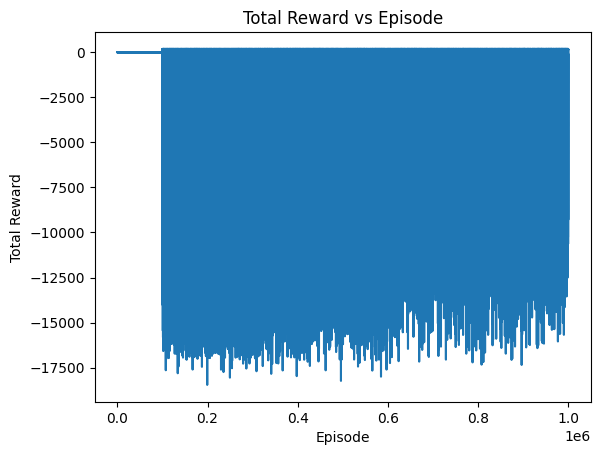

In [24]:
# plot the total reward
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [4]:
def lazy_table_q_learning(episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000, partial=0.5
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1 if i < partial*episode else 1000
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        # Setup global variables
        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal

        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent observations
            adjacent = {
                (taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col),
                (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1),
                (taxi_row, taxi_col)
            }

            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)

            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Goal logic
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 20
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 30
                        if saved:
                            print("Passenger Dropped in a wrong place")
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            # Compute next state
            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
                relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            # shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += reward

            if saved:
                print(f"Shaped_Reward: {reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='lazy_q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [5]:
lazy_q_table, lasy_reward = lazy_table_q_learning(episode = 100000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.001, epsilon_decay = 0.9999, memory = 100000, partial = 0.95)
save_q_table(lazy_q_table, filename='lazy_q_table.pkl')

 14%|█▎        | 13537/100000 [00:00<00:04, 18456.17it/s]

Episode: 10000/100000, Total Reward: -20.1, Steps: 1, Epsilon: 0.3679


 24%|██▍       | 24290/100000 [00:01<00:03, 20556.46it/s]

Episode: 20000/100000, Total Reward: -15.1, Steps: 1, Epsilon: 0.1353


 33%|███▎      | 32632/100000 [00:01<00:03, 20575.13it/s]

Episode: 30000/100000, Total Reward: -20.1, Steps: 1, Epsilon: 0.0498


 43%|████▎     | 43097/100000 [00:02<00:02, 20317.79it/s]

Episode: 40000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0183


 54%|█████▍    | 53754/100000 [00:02<00:02, 20334.53it/s]

Episode: 50000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0067


 65%|██████▍   | 64795/100000 [00:03<00:01, 20087.51it/s]

Episode: 60000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0025


 74%|███████▎  | 73638/100000 [00:03<00:01, 20386.09it/s]

Episode: 70000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


 84%|████████▍ | 83771/100000 [00:04<00:00, 19218.65it/s]

Episode: 80000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


 93%|█████████▎| 92639/100000 [00:04<00:00, 20447.32it/s]

Episode: 90000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


100%|██████████| 100000/100000 [00:40<00:00, 2480.69it/s]

==========================100000th episodes Start!==========================

Step: 1
Taxi Position: (1, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move West

. 🚖 . . . . B
. . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 2
Taxi Position: (0, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

🚖 . . . . . B
. . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 3
Taxi Position: (0, 1)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move North

. . . . . . B
🚖 . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 4
Taxi Position: (0, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

🚖 . . . . . B
. . . . . . .
. . . D . B .


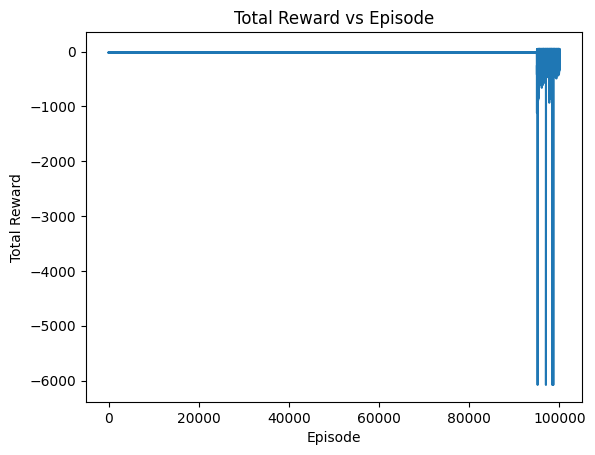

In [6]:
# plot the total reward
import matplotlib.pyplot as plt
plt.plot(lasy_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [ ]:
def simple_table_q_learning(
    episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            # shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += reward

            if saved:
                print(f"Shaped_Reward: {reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [ ]:
lazy_q_table, lasy_reward = lazy_table_q_learning(episode = 1000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.001, epsilon_decay = 0.9999, memory = 100000)
save_q_table(lazy_q_table, filename='simple_q_table.pkl')

100%|██████████| 1000/1000 [00:00<00:00, 11115.80it/s]


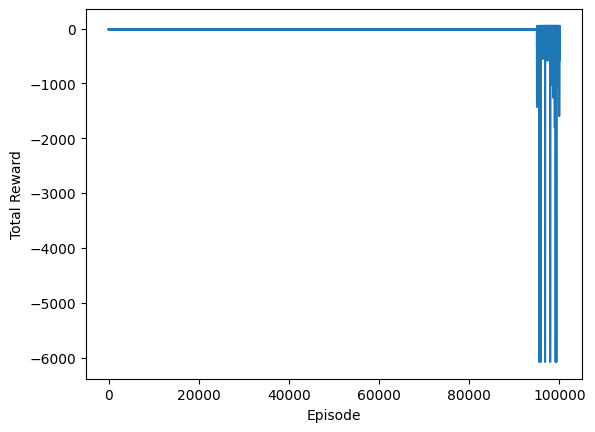

In [23]:
# plot the reward
import matplotlib.pyplot as plt
plt.plot(lasy_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()